In [21]:
import numpy as np
import sys 
sys.path.append('/home1/efeghhi/ripple_memory/analysis_code/')
from load_data import *
from analyze_data import *
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import decimate, resample

from mne.time_frequency import tfr_array_morlet
from scipy.signal import hilbert
from load_data_numpy import load_data_np

from pactools import Comodulogram, REFERENCES
from pactools.comodulogram import read_comodulogram
from pactools.bandpass_filter import multiple_band_pass
from pactools import simulate_pac
from theta_gamma_PAC import compute_entropy

def remove_session_string(subject_session_elec_string):
    
    subj_sess = subject_session_elec_string.split('_')[0]
    subj = subj_sess.split('-')[0]
    
    elec = subject_session_elec_string.split('_')[1]
    
    subj_elec = f"{subj}_{elec}"
    
    return subj_elec

if run_mode == 1:
    encoding_mode = 1
    saveName = 'encoding_'
    
if run_mode == 2:
    encoding_mode = 0
    saveName = 'recall_'
    
dd_trials = load_data_np(encoding_mode)

if encoding_mode:
    # relative to word onset 
    start_roi = 300
    end_roi = 1300
    
    # each trial consists of 5 sec of raw data, which starts
    # 1.7 before word onset and ends 3.3 sec after word onset 
    # the data is sampled at 500 Hz
    start_time = -1700
    end_time = 3300

else:
    
    start_roi = -1100
    end_roi = -100
    
    # for recall, 
    # each trial consists of 6 sec of data, centered around word recall 
    start_time = -3000
    end_time = 3000
    
sr_factor = 2

# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

print(start_idx, end_idx)

raw_data = dd_trials['raw']
clust = dd_trials['clust_int']

nonclust_idxs = np.argwhere(clust==0)
clust_idxs = np.argwhere(clust==1)
subj_elec_labels = np.array([remove_session_string(x) for x in dd_trials['elec_labels']])
subj_elec_clust_idxs = subj_elec_labels[clust_idxs].squeeze()
subj_elec_nonclust_idxs = subj_elec_labels[nonclust_idxs].squeeze()
raw_data_clust = raw_data[clust_idxs].squeeze()
raw_data_not_clust = raw_data[nonclust_idxs].squeeze()


def get_filtered_signal(raw_data, freq_range, start_idx, end_idx, fs):
    
    from mne.filter import filter_data
    
    n_frequencies = len(freq_range)
    n_epochs = raw_data.shape[0]
    n_points = raw_data.shape[1]
    
    filtered = np.zeros((n_frequencies, n_epochs, n_points),
                        dtype=np.complex128)
    
    for jj, frequency in enumerate(freq_range):
        
        bandpassed_data = filter_data(raw_data, sfreq=fs, l_freq=frequency[0], 
                                              h_freq=frequency[1], verbose=False)
        filtered[jj, :] = hilbert(bandpassed_data)
        
    return filtered[:, :, start_idx:end_idx]

def compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300):
    
    
    n_low = low_sig.shape[0]
    n_high = high_sig.shape[0]
    
    phase_vals = np.real(np.angle(low_sig))
    amplitude_vals = np.real(np.abs(high_sig))

    # add eps so that pi is included in a bin
    eps=1e-4
    phase_bins = np.linspace(-np.pi, np.pi+eps, n_bins+1)
    # get the indices of the bins to which each value in input belongs
    phase_preprocessed = np.digitize(phase_vals, phase_bins) - 1
    
    MI_vals = []
    phase_amp_hist_storage = []
    
    for low in range(n_low):
        
        phase = phase_preprocessed[low]
        
        for high in range(n_high):
            
            amp = amplitude_vals[high]
            MI_surrogates, amplitude_dist_surrogates = modulation_index(phase, amp, n_surrogates, n_bins, min_shift)
            
            MI_vals.append(MI_surrogates)
            phase_amp_hist_storage.append(amplitude_dist_surrogates)
            
            print(MI_surrogates[0]*1e4)
            
    return MI_vals, phase_amp_hist_storage

def circular_permute_within_epochs(data_arr, min_shift):
    
    n_epochs = data_arr.shape[0]
    n_points = data_arr.shape[1]
    
    data_arr_shuffled = np.zeros_like(data_arr)
    
    for epoch_idx in range(n_epochs):
        
        shift_val = np.random.randint(min_shift, n_points-min_shift)
        data_arr_shuffled[epoch_idx] = np.hstack((data_arr[epoch_idx, shift_val:], data_arr[epoch_idx, :shift_val]))
        
    return data_arr_shuffled

    
def modulation_index(phase, amplitude, n_surrogates, n_bins, min_shift):
    
    from copy import deepcopy
    
    MI_surrogates = []
    amplitude_dist_surrogates = []
    
    for n in range(n_surrogates+1):
         
        if n > 0:
            phase = circular_permute_within_epochs(phase, min_shift)
 
        phase_1d = np.ravel(phase)
        amplitude_1d = np.ravel(amplitude)
 
        amplitude_dist = np.ones(n_bins)  # default is 1 to avoid log(0)
        for b in np.unique(phase_1d):
            selection = amplitude_1d[phase_1d == b]
            amplitude_dist[b] = np.mean(selection)

        # Kullback-Leibler divergence of the distribution vs uniform
        amplitude_dist /= np.sum(amplitude_dist)
        divergence_kl = np.sum(
            amplitude_dist * np.log(amplitude_dist * n_bins))

        MI = divergence_kl / np.log(n_bins)
            
        MI_surrogates.append(MI)
        
        amplitude_dist_surrogates.append(amplitude_dist)
       
    
    return MI_surrogates, amplitude_dist_surrogates
    
    
savePath = '/home1/efeghhi/ripple_memory/analysis_code/pac_analyses/saved_results/comodulogram/'
low_fq_range = [[2,5],[6,10]]
high_fq_range = [[30,70], [80,120], [130,170]]
fs = 500

def save_MI_amplitude(subj_elec_idxs_all, raw_data, postfix_save, fs):


    for subj_elec in np.unique(subj_elec_idxs_all):

        save_dict = {}

        subj_elec_idxs = np.argwhere(subj_elec_idxs_all==subj_elec).squeeze()

        print(subj_elec)

        if subj_elec_idxs.shape[0] < 10:
            continue

        raw_data_elec_subj = raw_data[subj_elec_idxs].squeeze()

        low_sig = get_filtered_signal(raw_data_elec_subj, low_fq_range, start_idx, end_idx, fs=fs)
        high_sig = get_filtered_signal(raw_data_elec_subj, high_fq_range, start_idx, end_idx, fs=fs)
 
        MI, pac_hist = compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300)

        save_dict['MI'] = MI
        save_dict['pac_hist'] = pac_hist

        np.savez(f'{savePath}{subj_elec}_{postfix_save}', **save_dict)
        
        print("SAVED DATA")


save_MI_amplitude(subj_elec_clust_idxs, raw_data_clust, 'clust', fs)
save_MI_amplitude(subj_elec_nonclust_idxs, raw_data_not_clust, 'not_clust', fs)

Loading data
Number of trials in ca1: 55356
order: C
1000 1500
R1065J_LE2-LE3
0.7739199999549784
1.8193469858894618
0.7574656582589265
0.05994775497067802
0.2729546419785524
0.3449074693002833
SAVED DATA
R1065J_LS1-LS2


KeyboardInterrupt: 

In [14]:
MI[1][0]

0.0002035585498273122

In [1]:
import numpy as np
import sys 
sys.path.append('/home1/efeghhi/ripple_memory/analysis_code/')
from load_data import *
from analyze_data import *
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import decimate, resample

from mne.time_frequency import tfr_array_morlet
from scipy.signal import hilbert
from load_data_numpy import load_data_np

from pactools import Comodulogram, REFERENCES
from pactools.comodulogram import read_comodulogram
from pactools.bandpass_filter import multiple_band_pass
from pactools import simulate_pac
from theta_gamma_PAC import compute_entropy

def remove_session_string(subject_session_elec_string):
    
    subj_sess = subject_session_elec_string.split('_')[0]
    subj = subj_sess.split('-')[0]
    
    elec = subject_session_elec_string.split('_')[1]
    
    subj_elec = f"{subj}_{elec}"
    
    return subj_elec

if run_mode == 1:
    encoding_mode = 1
    saveName = 'encoding_'
    
if run_mode == 2:
    encoding_mode = 0
    saveName = 'recall_'
    
dd_trials = load_data_np(encoding_mode)

if encoding_mode:
    # relative to word onset 
    start_roi = 300
    end_roi = 1300
    
    # each trial consists of 5 sec of raw data, which starts
    # 1.7 before word onset and ends 3.3 sec after word onset 
    # the data is sampled at 500 Hz
    start_time = -1700
    end_time = 3300

else:
    
    start_roi = -1100
    end_roi = -100
    
    # for recall, 
    # each trial consists of 6 sec of data, centered around word recall 
    start_time = -3000
    end_time = 3000
    
sr_factor = 2

# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

print(start_idx, end_idx)

raw_data = dd_trials['raw']
clust = dd_trials['clust_int']

nonclust_idxs = np.argwhere(clust==0)
clust_idxs = np.argwhere(clust==1)
subj_elec_labels = np.array([remove_session_string(x) for x in dd_trials['elec_labels']])
subj_elec_clust_idxs = subj_elec_labels[clust_idxs].squeeze()
subj_elec_nonclust_idxs = subj_elec_labels[nonclust_idxs].squeeze()
raw_data_clust = raw_data[clust_idxs].squeeze()
raw_data_not_clust = raw_data[nonclust_idxs].squeeze()


def get_filtered_signal(raw_data, freq_range, start_idx, end_idx):
    
    from mne.filter import filter_data
    
    n_frequencies = len(freq_range)
    n_epochs = raw_data.shape[0]
    n_points = raw_data.shape[1]
    
    filtered = np.zeros((n_frequencies, n_epochs, n_points),
                        dtype=np.complex128)
    
    for jj, frequency in enumerate(freq_range):
        
        bandpassed_data = filter_data(raw_data, sfreq=fs, l_freq=frequency[0], 
                                              h_freq=frequency[1], verbose=False)
        filtered[jj, :] = hilbert(bandpassed_data)
        
    return filtered[:, :, start_idx:end_idx]

def compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300):
    
    
    n_low = low_sig.shape[0]
    n_high = high_sig.shape[0]
    
    phase_vals = np.real(np.angle(low_sig))
    amplitude_vals = np.real(np.abs(high_sig))

    # add eps so that pi is included in a bin
    eps=1e-4
    phase_bins = np.linspace(-np.pi, np.pi+eps, n_bins+1)
    # get the indices of the bins to which each value in input belongs
    phase_preprocessed = np.digitize(phase_vals, phase_bins) - 1
    
    MI_vals = np.zeros((n_low, n_high))
    MI_z_vals = np.zeros((n_low, n_high))
    phase_amp_hist_storage = []
    
    for low in range(n_low):
        
        phase = phase_preprocessed[low]
        
        for high in range(n_high):
            
            amp = amplitude_vals[high]

            MI, MI_z, phase_amp_hist = modulation_index(phase, amp, n_surrogates, n_bins, min_shift)
            MI_vals[low, high] = MI
            MI_z_vals[low, high] = MI_z
            phase_amp_hist_storage.append(phase_amp_hist)
            
    return MI_vals, MI_z_vals, phase_amp_hist_storage

def circular_permute_within_epochs(data_arr, min_shift):
    
    n_epochs = data_arr.shape[0]
    n_points = data_arr.shape[1]
    
    data_arr_shuffled = np.zeros_like(data_arr)
    
    for epoch_idx in range(n_epochs):
        
        shift_val = np.random.randint(min_shift, n_points-min_shift)
        data_arr_shuffled[epoch_idx] = np.hstack((data_arr[epoch_idx, shift_val:], data_arr[epoch_idx, :shift_val]))
        
    return data_arr_shuffled

    
def modulation_index(phase, amplitude, n_surrogates, n_bins, min_shift):
    
    from copy import deepcopy
    
    MI_surrogates = []
    amplitude_dist_surrogates = []
    
    print(np.unique(phase))
    
    for n in range(n_surrogates+1):
         
        if n > 0:
            phase = circular_permute_within_epochs(phase, min_shift)
 
        phase_1d = np.ravel(phase)
        amplitude_1d = np.ravel(amplitude)
 
        amplitude_dist = np.ones(n_bins)  # default is 1 to avoid log(0)
        for b in np.unique(phase_1d):
            selection = amplitude_1d[phase_1d == b]
            amplitude_dist[b] = np.mean(selection)

        # Kullback-Leibler divergence of the distribution vs uniform
        amplitude_dist /= np.sum(amplitude_dist)
        divergence_kl = np.sum(
            amplitude_dist * np.log(amplitude_dist * n_bins))

        MI = divergence_kl / np.log(n_bins)
            
        MI_surrogates.append(MI)
        
        amplitude_dist_surrogates.append(amplitude_dist)
       
    
    return MI_surrogates, amplitude_dist_surrogates
    
    
savePath = '/home1/efeghhi/ripple_memory/analysis_code/pac_analyses/saved_results/comodulogram/'
low_fq_range = [[2,5],[6,10]]
high_fq_range = [[30,70], [80,120], [130,170]]

def save_MI_amplitude(subj_elec_idxs_all, raw_data, postfix_save):


    for subj_elec in np.unique(subj_elec_idxs_all):

        save_dict = {}

        subj_elec_idxs = np.argwhere(subj_elec_idxs_all==subj_elec).squeeze()

        print(subj_elec)

        if subj_elec_idxs.shape[0] < 10:
            continue

        raw_data_elec_subj = raw_data[subj_elec_idxs].squeeze()

        low_sig = get_filtered_signal(raw_data_elec_subj, low_fq_range, start_idx, end_idx)
        high_sig = get_filtered_signal(raw_data_elec_subj, high_fq_range, start_idx, end_idx)

        MI, pac_hist = compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300)

        save_dict['MI'] = MI
        save_dict['pac_hist'] = pac_hist
        
        sns.heatmap(MI[0].T)

        np.savez(f'{savePath}{subj_elec}_{postfix_save}')
        
        print("SAVED DATA")
        
        break

save_MI_amplitude(subj_elec_clust_idxs, raw_data_clust, 'clust')

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home1/efeghhi/.conda/envs/env3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.u

NameError: name 'run_mode' is not defined

In [15]:
def get_filtered_signal(raw_data, freq_range, start_idx, end_idx):
    
    from mne.filter import filter_data
    
    n_frequencies = len(freq_range)
    n_epochs = raw_data.shape[0]
    n_points = raw_data.shape[1]
    
    filtered = np.zeros((n_frequencies, n_epochs, n_points),
                        dtype=np.complex128)
    
    for jj, frequency in enumerate(freq_range):
        
        bandpassed_data = filter_data(raw_data, sfreq=fs, l_freq=frequency[0], 
                                              h_freq=frequency[1], verbose=False)
        filtered[jj, :] = hilbert(bandpassed_data)
        
    return filtered[:, :, start_idx:end_idx]

def compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300):
    
    
    n_low = low_sig.shape[0]
    n_high = high_sig.shape[0]
    
    phase_vals = np.real(np.angle(low_sig))
    amplitude_vals = np.real(np.abs(high_sig))

    phase_bins = np.linspace(-np.pi, np.pi+1e-4, n_bins+1)
    # get the indices of the bins to which each value in input belongs
    phase_preprocessed = np.digitize(phase_vals, phase_bins) - 1
    
    MI_vals = np.zeros((n_low, n_high))
    MI_z_vals = np.zeros((n_low, n_high))
    phase_amp_hist_storage = []
    
    for low in range(n_low):
        
        phase = phase_preprocessed[low]
        
        for high in range(n_high):
            
            amp = amplitude_vals[high]

            MI, MI_z, phase_amp_hist = modulation_index(phase, amp, n_surrogates, n_bins, min_shift)
            MI_vals[low, high] = MI
            MI_z_vals[low, high] = MI_z
            phase_amp_hist_storage.append(phase_amp_hist)
            
    return MI_vals, MI_z_vals, phase_amp_hist_storage

def circular_permute_within_epochs(data_arr, min_shift):
    
    n_epochs = data_arr.shape[0]
    n_points = data_arr.shape[1]
    
    data_arr_shuffled = np.zeros_like(data_arr)
    
    for epoch_idx in range(n_epochs):
        
        shift_val = np.random.randint(min_shift, n_points-min_shift)
        data_arr_shuffled[epoch_idx] = np.hstack((data_arr[epoch_idx, shift_val:], data_arr[epoch_idx, :shift_val]))
        
    return data_arr_shuffled

def modify_phase(phase):
    
    return np.roll(phase, 10)
    
def modulation_index(phase, amplitude, n_surrogates, n_bins, min_shift):
    
    from copy import deepcopy
    
    MI_surrogates = []
    
    for n in range(n_surrogates+1):
        
        if n > 0:
            #phase = np.random.poisson(size=phase.shape, lam=2)
            #phase = circular_permute_within_epochs(phase, min_shift)
            #phase = np.ones_like(phase)
            phase = np.roll(phase, 10)

            
        phase_1d = np.ravel(phase)
        amplitude_1d = np.ravel(amplitude)
 
        amplitude_dist = np.ones(n_bins)  # default is 1 to avoid log(0)
        for b in np.unique(phase_1d):
            selection = amplitude_1d[phase_1d == b]
            amplitude_dist[b] = np.mean(selection)

        # Kullback-Leibler divergence of the distribution vs uniform
        amplitude_dist /= np.sum(amplitude_dist)
        divergence_kl = np.sum(
            amplitude_dist * np.log(amplitude_dist * n_bins))

        MI = divergence_kl / np.log(n_bins)
            
        MI_surrogates.append(MI)
        
    
    MI = MI_surrogates[0]
    MI_z = (MI - np.mean(MI_surrogates[1:]))/np.std(MI_surrogates[1:])
    
    return MI, MI_z, amplitude_dist
    

In [19]:
savePath = '/home1/efeghhi/ripple_memory/analysis_code/pac_analyses/saved_results/comodulogram/'
low_fq_range = [[2,4],[5,10]]
high_fq_range = [[30,70], [80,120], [130,170]]

R1065J_LE2-LE3


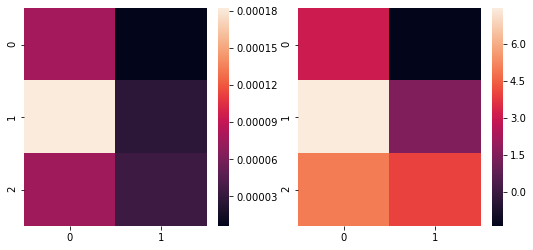

[[7.73920000e-05 5.99477550e-06]
 [1.81934699e-04 2.72954642e-05]
 [7.57465658e-05 3.44907469e-05]]


In [20]:
save_dict = {}

for subj_elec in np.unique(subj_elec_clust_idxs):
    
    subj_elec_idxs = np.argwhere(subj_elec_clust_idxs==subj_elec).squeeze()
    
    print(subj_elec)
    
    if subj_elec_idxs.shape[0] < 10:
        continue
        
    raw_data_clust_elec_subj = raw_data_clust[subj_elec_idxs].squeeze()
    
    low_sig = get_filtered_signal(raw_data_clust_elec_subj, low_fq_range, start_idx, end_idx)
    high_sig = get_filtered_signal(raw_data_clust_elec_subj, high_fq_range, start_idx, end_idx)
    
    MI, MI_z, pac_hist = compute_pac(low_sig, high_sig, n_bins=18, min_shift=50, n_surrogates=300)
    
    save_dict['MI'] = MI
    save_dict['MI_z'] = MI_z
    save_dict['pac_hist'] = pac_hist
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

    # Plot data on the first subplot
    sns.heatmap(MI.T, ax=ax1)
    sns.heatmap(MI_z.T, ax=ax2)
    plt.show()
    
    print(MI.T)
    break
    
    
    



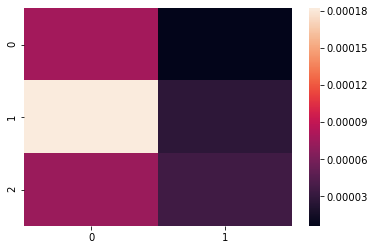

In [155]:
sns.heatmap(MI.T)

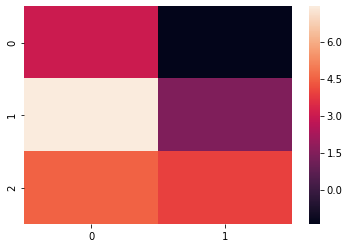

In [156]:
sns.heatmap(MI_z.T)